# Let's read in our data and take a look at which variables we have.


In [13]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# f = xr.open_mfdataset('/home/hma000/accomatic-web/tests/test_data/nc/obs_85_gst.nc')


In [1]:
try: f.close()
except: pass
year = 1980
f = xr.open_mfdataset(f'/home/hma000/storage/yk_kdi_ldg/scaled/scaled_era5_1h_{year}.nc')
df = f.to_pandas()
print(df.head())

In [ ]:
f2 = xr.open_mfdataset('/home/hma000/storage/yk_kdi_ldg/scaled/scaled_era5_1h_1980.nc', engine="netcdf4")
for i in ['merra2','jra55']:
    f = xr.open_mfdataset(f'/fs/yedoma/data/globsim/YK-KDI-LDG_scaled_for_geotop/scaled_{i}_1h.nc', engine="netcdf4")
    f['station_name'] = f2['station_name']
    f.to_netcdf(path=f'/fs/yedoma/data/globsim/YK-KDI-LDG_scaled_for_geotop/scaled_{i}_1h_stn.nc', mode='w')
    f.close()
    print(f"{i} is complete. ")
f2.close()

: 

# To a dataframe



# Info required:
For GST, 0.50m and 1.0m
- Number of sites, number of years for each cluster
        Of the 85 plots we have observational data for, X have observations at 0.5 m and Y have observations at 1.0 m depth.

Missing data
of all timeseries; how many have complete years? How much do we increase the amount of data we have by using months? 



In [4]:
f = xr.open_mfdataset('/home/hma000/storage/yk_kdi_ldg/scaled/.nc', engine="netcdf4")
df = f.to_dataframe()
df = df.reset_index(drop=False)
df = df.drop(columns=['latitude', 'longitude','elevation','station'])
df.platform_id = [line.decode("utf-8") for line in df.platform_id]
df.platform_id = [line.split("_")[0] for line in df.platform_id.str[:]]
# ROCK1A -> ROCK1
df.platform_id = [line.rstrip("ABC") for line in df.platform_id.str[:]]

#df = df.dropna()
df = df.set_index(pd.DatetimeIndex(df.time)).drop(columns='time')

df["temp_site_date"] = df.platform_id + df.index.astype(str)
df.soil_temperature = df.groupby("temp_site_date")["soil_temperature"].transform("mean")

df = df.drop_duplicates(subset=["temp_site_date"], keep="first").drop(columns='temp_site_date')


df = df.rename(columns={"soil_temperature": "obs"})
df['clust'] = df['platform_id'].str[:2]
df.clust.replace(['RO','Bu'], 'NG', inplace=True)
all_data = df.dropna()


In [43]:
def missing(df):
    years_site = 0
    months_site = 0
    for year in df.index.year.unique():
        d_year = df[df.index.year == year]
        diff = len(pd.date_range(start=f'{year}/01/01', end=f'{year}/12/31').difference(d_year.index))
        
        if diff > 0:
            for month in d_year.index.month.unique():
                d_month = d_year[d_year.index.month == month]
                if len(pd.date_range(start=f'{year}/{month}/01', end=f'{year}/{month}/28').difference(d_month.index)) == 0:
                    months_site = months_site + 1
                    
        else:
            years_site = years_site + 1
    return(f"{years_site},{months_site}")


df = all_data.dropna()

# print(missing(df))
# KDI-W-Wet2 34 133

write_file = "missing_data.csv"
with open(write_file, "wt", encoding="utf-8") as output:
    output.write('clust,sitename,years,months,depth\n')
    for clust in df.clust.unique():
        d = df[df.clust == clust]
        for depth in d.depth.unique():
            if depth > 0.001:
                dd = d[d.depth == depth]
                for site in dd.platform_id.unique():
                    data = missing(dd[dd.platform_id == site])
                    # missing(dd) = " tot_years, tot_months "
                    line = f'{clust},{site},{missing(dd)},{str(round(depth, 2))}'
                    output.write(line + '\n')


In [54]:
df = pd.read_csv('missing_data.csv')
print(df.head())

df01 = df[df.depth == 0.1]
df05 = df[df.depth == 0.5]

out1 = f"Across all three clusters recording ground temperatures, there are {len(df01)} GST plots and {len(df05)} plots with boreholes recording data at 0.50 m depth. "


out2 = f"There are a total of {df01.years.sum()} complete years of data across all GST plots (LDG: {df01[df01.clust == 'NG'].years.sum()}, KDI: {df01[df01.clust == 'KD'].years.sum()}, YK: {df01[df01.clust == 'YK'].years.sum()}), and {df[df.depth == 0.5].years.sum()} complete years of 0.50 m data."

out3 = f"If only complete years of data are to be used for model evaluation, there are an additional {df01.months.sum()} months ({round(df01.months.sum()/12, 1)} years) of GST data that could contribute to model evaluation. Additionally, there are {df05.months.sum()} months ({round(df05.months.sum()/12, 1)} years) of ground temperature data at 0.50 m depth. Through subsetting observational data by month, and bootstrapping the sorted data, we are able to produce confidence intervals around model results that reflect the amount of data being used."

print(out1)
print(out2)
print(out3)




  clust     sitename  years  months  depth
0    NG   NGO-RC-169      6      13    0.1
1    NG  Bushloggers      6      13    0.1
2    NG   NGO-RC-170      6      13    0.1
3    NG   NGO-RC-171      6      13    0.1
4    NG   NGO-RC-162      6      13    0.1
Across all three clusters recording ground temperatures, there are 73 GST plots and 12 plots with boreholes recording data at 0.50 m depth. 
There are a total of 394 complete years of data across all GST plots (LDG: 270, KDI: 24, YK: 100), and 36 complete years of 0.50 m data.
If only complete years of data are to be used for model evaluation, there are an additional 941 months (78.4 years) of GST data that could contribute to model evaluation. Additionally, there are 144 months (12.0 years) of ground temperature data at 0.50 m depth. Through subsetting observational data by month, and bootstrapping the sorted data, we are able to produce confidence intervals around model results that reflect the amount of data being used.


# Now pull out variables & explore their dimensions and shape.

In [8]:
files = ['/home/hma000/storage/yk_kdi_ldg/scaled/temp/scaled_merra2_1h_198.nc']
pth = ''#'/home/hma000/storage/scaled/'
l = []
for file in files:
    f = xr.open_mfdataset(f'{pth}{file}')
    df = f.to_dataframe().reset_index()
    print(df.columns)
    import sys
    sys.exit()
    df.station_name = [line.decode("utf-8") for line in df.station_name]
    df['clust'] = df['station_name'].str[:2]
    df = df[["time","clust", "PREC_sur", "AIRT_sur"]]
    df['reanal'] = file.split('_')[2]
    l.append(df)

df = pd.concat(l)
df = df[["time","clust", "PREC_sur", "AIRT_sur", "reanal"]].set_index("time")
df.clust.replace('RO', 'NG', inplace=True)




Index(['time', 'station', 'PRESS_pl', 'AIRT_pl', 'AIRT_sur', 'PREC_sur',
       '_sur', 'RH_sur', 'WSPD_sur', 'WDIR_sur', 'SW_sur', 'LW_sur',
       'SH_sur'],
      dtype='object')


SystemExit: 

/home/hma000/.conda/envs/acco/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [105]:
#df = pd.read_csv("reanal_data.csv", index_col='time')

write_file = "reanal_data_summary.csv"
with open(write_file, "wt", encoding="utf-8") as output:
    output.write('clust,reanalysis,AIRT_sur,PREC_sur\n')
    
    for clust in df.clust.unique():
        df_cluster = df[df.clust == clust].drop(columns = 'clust')
        df_cluster.index = pd.to_datetime(df_cluster.index)
        for data in df.reanal.unique():
            df_reanal = df_cluster[df_cluster.reanal == data].drop(columns='reanal')
            df_reanal["day-month"] = df_reanal.index.strftime("%m-%d")
            df_reanal = df_reanal.groupby(["day-month"]).mean()
            
            output.write(f"{clust},{data},{df[df.clust == clust].AIRT_sur.mean()},{df_reanal.PREC_sur.sum() * 86400}")

# YK merra2 -4.2771428683012 2347.816817827837
# YK jra55 -4.2771428683012 404.3426425200845
# YK era5 -4.2771428683012 300.2302638794914
# KD merra2 -7.907279057622825 672.3679007197125
# KD jra55 -7.907279057622825 470.5752570706752
# KD era5 -7.907279057622825 390.987822480963
# NG merra2 -8.046546125527518 537.2239179484735
# NG jra55 -8.046546125527518 447.7038535511782
# NG era5 -8.046546125527518 399.3422557350242

In [ ]:
df.info

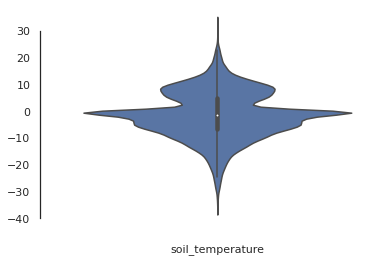

In [22]:
f, ax = plt.subplots()
df.unstack()
sns.violinplot(data=df)
sns.despine(offset=10, trim=True)

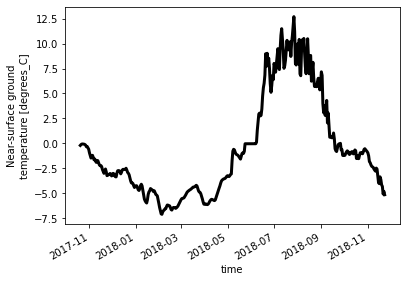

In [50]:
import matplotlib.pyplot as plt

f.soil_temperature[1, :].plot(color='#008080', linewidth=1.5)
f.soil_temperature[2, :].plot(color='#F3700E', linewidth=1.5)
f.soil_temperature[3, :].plot(color='#F50B00', linewidth=1.5)

plt.savefig("timeseries_obs.pdf",transparent=True)

# Right now temp and time are _variables_ If we want to actually access this data, we use "[ ]":

In [18]:
print("Temp data looks like: %s (Units: %s)" % (temp[0,0], temp.units)) # Simulation_index = 0, depth_index = 0
print('Our time data is from %s to %s' % (time[0], time[-1]))

Temp data looks like: <xarray.DataArray 'soil_temperature' ()>
array(13.1268)
Coordinates:
    time     datetime64[ns] 2017-07-12
Attributes:
    units:          degrees_C
    long_name:      Near-surface ground temperature
    coordinates:    station_name time height latitude longitude
    standard_name:  soil_temperature
    grid_mapping:   crs (Units: degrees_C)
Our time data is from <xarray.DataArray 'time' ()>
array('2017-07-12T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-07-12
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    cf_role:        profile_id to <xarray.DataArray 'time' ()>
array('2021-08-22T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-08-22
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    cf_role:        profile_id


# What is the time extent of our data? How can we reformat this ugly bs?

In [30]:
from netCDF4 import num2date

start, end = [date.strftime('%Y-%m-%d %H:%M:%S') for date in num2date(time[:2], time.units)]
print('Or, in other words: %s to %s' % (start, end))

Or, in other words: 1990-01-01 02:00:00 to 1990-01-01 03:00:00


# How can I plot this? Let's say, temperature at 0.1m depth in 1991.

First, we have to pick out our desired time extent.

In [31]:
from datetime import datetime
import numpy as np

year = 1991
#mdates.set_epoch('0001-01-01T00:00')
print(mdates.get_epoch())
#if mdates.get_epoch() != '0001-01-01T00:00': mdates.set_epoch('0001-01-01T00:00')

1970-01-01T00:00:00


# Nice! Now, time to plot 1991 temp data.

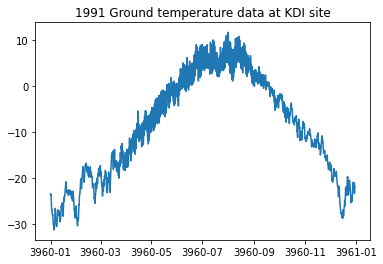

In [32]:
import matplotlib.pyplot as plt

start = (datetime(year, 1, 1, 0, 0, 0) - datetime(1, 1, 1, 0, 0, 0)).total_seconds() / 86400
end = (datetime(year, 12, 31, 23, 0, 0) - datetime(1, 1, 1, 0, 0, 0)).total_seconds() / 86400
time_select = np.logical_and(time[:] > start, time[:] < end)

data = temp[0, time_select, 0] # data = temp[simulation_index, time_select, depth_index]
plt.title("%s Ground temperature data at KDI site" % year)
plt.plot(mdates.num2date(time[time_select]), data[:])
plt.show()

What if we want to add a new variable to our dataset?
open a new dataset

In [33]:
# .nc file has groups of simulations -> each group has data for each site
# geotop_merra: site1, site2, site3
# geotop_jra: site1, site2, site3
# geotop_erai: site1, site2, site3
# acco: site1, site2, site3

acco = ncfile['acco']
if 'nchars' not in acco.dimensions.keys():
    acco.createDimension('nchars', f.dimensions['nchars'].size)

if 'simulation' not in acco.dimensions.keys():
    acco.createDimension('simulation', f.dimensions['simulation'].size)

if 'simulation' not in acco.variables.keys():
    acco.createVariable('simulation', f.variables['simulation'].datatype, f.variables['simulation'].dimensions)
    acco.variables['simulation'] = f.variables['simulation']

if 'time' not in acco.dimensions.keys():
    acco.createDimension('time', f.dimensions['time'].size)

if 'Date' not in acco.variables.keys():
    acco.createVariable('Date', f.variables['Date'].datatype, f.variables['Date'].dimensions)
    acco.variables['Date'] = f.variables['Date']

IndexError: acco not found in /

In [26]:
ncfile.close()